In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as utils
from torchvision.utils import save_image
from torchvision import models
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.nn.functional as F
from scipy import linalg

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def initialize_weights(model):
    if isinstance(model, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif isinstance(model, nn.BatchNorm2d):
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

def generate_random_text(batch_size, text_dim, device):
    return torch.randn(batch_size, text_dim, device=device)

def create_dataloader():
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    return DataLoader(train_dataset, batch_size=128, num_workers=2, shuffle=True)

In [3]:
class Generator(nn.Module):
    def __init__(self, text_input_dim, noise_dim, initial_features=512, num_channels=3):
        super(Generator, self).__init__()
        text_feature_dim = 256
        feature_map_size = initial_features * 4 * 4
        
        self.text_embedding = nn.Sequential(
            nn.Linear(text_input_dim, text_feature_dim),
            nn.ReLU(),
        )
        
        self.generator_network = nn.Sequential(
            nn.Linear(noise_dim + text_feature_dim, feature_map_size),
            nn.BatchNorm1d(feature_map_size),
            nn.ReLU(),
            nn.Unflatten(1, (initial_features, 4, 4)),
            self._upsample_layer(initial_features, 256),
            self._upsample_layer(256, 128),
            self._upsample_layer(128, 64),
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1),
            nn.Tanh()
        )

    def _upsample_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, text_input, noise):
        text_embedding = self.text_embedding(text_input)
        noise = noise.view(noise.size(0), -1)
        x = torch.cat([noise, text_embedding], dim=1)
        return self.generator_network(x)

class Discriminator(nn.Module):
    def __init__(self, text_input_dim, num_channels):
        super(Discriminator, self).__init__()
        text_feature_dim = 256
        final_feature_map_size = 512 * 4 * 4
        
        self.text_embedding = nn.Sequential(
            nn.Linear(text_input_dim, text_feature_dim),
            nn.ReLU(),
        )
        
        self.discriminator_network = nn.Sequential(
            nn.Conv2d(num_channels, 64, 5, 2, 2),
            nn.LeakyReLU(0.2),
            self._conv_layer(64, 128),
            self._conv_layer(128, 256),
            self._conv_layer(256, 512)
        )
        self.concat = nn.Sequential(
            nn.Flatten(),
            nn.Linear(final_feature_map_size + text_feature_dim, 1)
        )

    def _conv_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 5, 2, 2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, image_input, text_input):
        text_embedding = self.text_embedding(text_input)
        text_embedding = text_embedding.view(-1, 256)
        image_features = self.discriminator_network(image_input).view(image_input.size(0), -1)
        combined = torch.cat([image_features, text_embedding], dim=1)
        return self.concat(combined)

In [4]:
class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3

    BLOCK_INDEX_BY_DIM = {
        64: 0,
        192: 1,
        768: 2,
        2048: 3
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1 

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

In [5]:
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [6]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_frechet(images_real,images_fake):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
    model = InceptionV3([block_idx])
    model=model.cuda()
    mu_1,std_1 = calculate_activation_statistics(images_real,model,cuda=True)
    mu_2,std_2 = calculate_activation_statistics(images_fake,model,cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [7]:
def calculate_gradient_penalty(D, real_s, fake_s, text_in, device):
    alp = torch.rand((real_s.size(0), 1, 1, 1), device=device)
    inter_p = (alp * real_s + ((1 - alp) * fake_s)).requires_grad_(True)
    d_inter_pol = D(inter_p, text_in)
    fake = torch.ones(d_inter_pol.shape, device=device, requires_grad=False)
    gradi = torch.autograd.grad(
        outputs=d_inter_pol,
        inputs=inter_p,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gp = ((gradi.norm(2, dim=1) - 1) ** 2).mean()
    return gp

In [8]:
def train_gan(generator, discriminator, dataloader, device, num_epochs, noise_dim, text_input_dim, fixed_noise, text_input_batch):
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    generator.train(), discriminator.train()
    
    gen_losses = []
    dis_losses = []
    frechet_distances = []
    image_list = [] 
    output_dir = 'WGAN_Output'
    os.makedirs(output_dir, exist_ok=True)
    it = 0  
    critic_it = 5
    lambda_gp = 10

    print("Training has started...")
    for epoch in range(num_epochs):
        for i, (imgs, _) in enumerate(dataloader):
            real_imgs = imgs.to(device)
            b_size = real_imgs.size(0)
            real_text_in = generate_random_text(b_size, text_input_dim, device)
            fake_text_in = generate_random_text(b_size, text_input_dim, device)

            for _ in range(critic_it):
                discriminator.zero_grad()
                noise = torch.randn(b_size, noise_dim, device=device) 
                fake_imgs = generator(fake_text_in, noise).detach()

                real_predictions = discriminator(real_imgs, real_text_in)
                fake_predictions = discriminator(fake_imgs, fake_text_in)
                d_loss_real = -torch.mean(real_predictions)
                d_loss_fake = torch.mean(fake_predictions)

                gp = calculate_gradient_penalty(discriminator, real_imgs, fake_imgs, real_text_in, device)
                disc_loss = d_loss_real + d_loss_fake + lambda_gp * gp
                disc_loss.backward()
                optimizerD.step()

            generator.zero_grad()
            generated_imgs = generator(fake_text_in, noise)
            gen_loss = -torch.mean(discriminator(generated_imgs, fake_text_in))
            gen_loss.backward()
            optimizerG.step()

            gen_losses.append(gen_loss.detach().cpu())
            dis_losses.append(disc_loss.detach().cpu())

            if it % 300 == 0 or ((epoch == num_epochs-1) and (i == len(dataloader) - 1)):
                with torch.no_grad():
                    fake_imgs = generator(text_input_batch, fixed_noise).detach().cpu()
                image_list.append(utils.make_grid(fake_imgs, padding=2, normalize=True))

            it += 1

        with torch.no_grad():
            frechet_distance = calculate_frechet(real_imgs.cpu(), generated_imgs.cpu())
        frechet_distances.append(frechet_distance)

        if epoch % 5 == 0:
            print(f'\nEpoch: [{epoch}/{num_epochs}], Batch: {i}/{len(dataloader)}, Discriminator Loss: {disc_loss.item():.3f}, Generator Loss: {gen_loss.item():.3f}, FID score: {frechet_distance:.3f}')
            with torch.no_grad():
                imgs = generator(text_input_batch, fixed_noise).detach()
        img_fake_path = os.path.join(output_dir, f'fake_imgs_epoch_{epoch+1:03d}.png')
        img_real_path = os.path.join(output_dir, f'real_imgs_epoch_{epoch+1:03d}.png')
        utils.save_image(generated_imgs.detach(), img_fake_path, normalize=True)
        utils.save_image(real_imgs.detach(), img_real_path, normalize=True)

    return gen_losses, dis_losses, frechet_distances, image_list

In [9]:
def plot_loss_FID_graph(generator_losses, discriminator_losses, frechet_distances, output_dir, num_epochs):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(generator_losses, label="Generator")
    plt.plot(discriminator_losses, label="Discriminator")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator and Discriminator Training Loss")

    plt.subplot(2, 1, 2)
    plt.plot(frechet_distances, label="Frechet Distance")
    plt.xlabel("Epoch")
    plt.ylabel("Frechet Distance")
    plt.legend()
    plt.title("FIDs vs Epochs for WGAN")
    plt.subplots_adjust(hspace=0.5)
    plt.savefig(f'{output_dir}/training_progress.png')
    plt.show()
    
def plot_real_and_fake_images(dataloader, img_list, output_dir):
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=5, normalize=True).cpu(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.savefig(f'{output_dir}/WGAN_BEST_FAKE_Images.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
def save_losses_and_distances(output_dir, generator_losses, discriminator_losses, frechet_distances):
    with open(os.path.join(output_dir, 'WGAN_generator_losses.txt'), 'w') as file:
        for loss in generator_losses:
            file.write(f"{loss}\n")
    with open(os.path.join(output_dir, 'WGAN_discriminator_losses.txt'), 'w') as file:
        for loss in discriminator_losses:
            file.write(f"{loss}\n")
    with open(os.path.join(output_dir, 'WGAN_frechet_distances.txt'), 'w') as file:
        for distance in frechet_distances:
            file.write(f"{distance}\n")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Training has started...


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.10-dtqfczcbv33ugxmsznhll4vjexdcxjfn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: [0/50], Batch: 390/391, Discriminator Loss: -6297.703, Generator Loss: 2763.008, FID score: 391.961

Epoch: [5/50], Batch: 390/391, Discriminator Loss: -1493.631, Generator Loss: -12166.252, FID score: 287.821

Epoch: [10/50], Batch: 390/391, Discriminator Loss: -210.347, Generator Loss: 15677.570, FID score: 258.740

Epoch: [15/50], Batch: 390/391, Discriminator Loss: -248.767, Generator Loss: -19648.287, FID score: 286.152

Epoch: [20/50], Batch: 390/391, Discriminator Loss: -560.220, Generator Loss: -17791.889, FID score: 288.390

Epoch: [25/50], Batch: 390/391, Discriminator Loss: -188.294, Generator Loss: -1698.227, FID score: 259.298

Epoch: [30/50], Batch: 390/391, Discriminator Loss: -643.844, Generator Loss: -665.339, FID score: 222.770

Epoch: [35/50], Batch: 390/391, Discriminator Loss: -32.335, Generator Loss: -60180.062, FID score: 258.792

Epoch: [40/50], Batch: 390/391, Discriminator Loss: 723.058, Generator Loss: -123143.352, FID score: 397.338

Epoch: [45/50], 

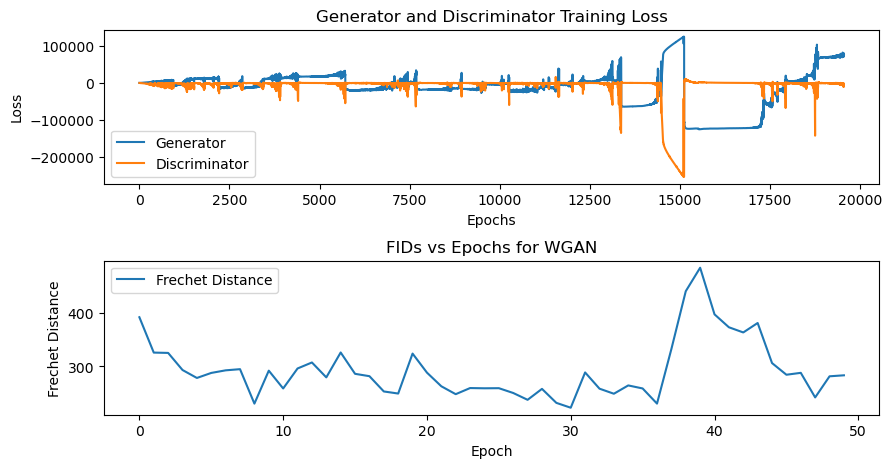

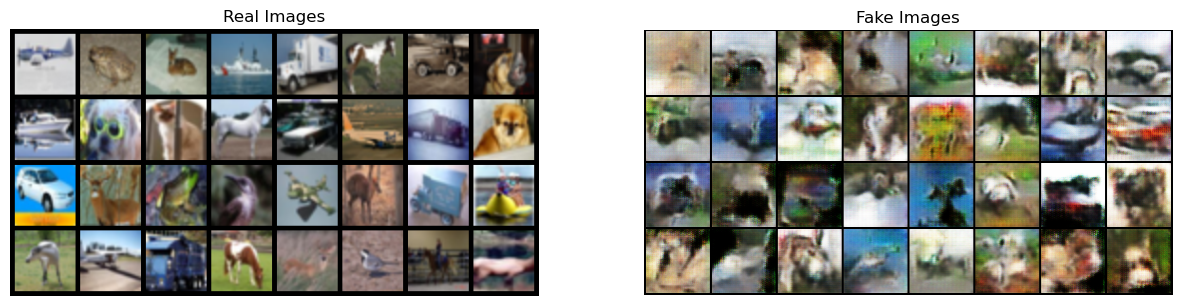

In [10]:
def main():
    dataloader = create_dataloader()
    noise_dim = 100  
    text_input_dim = 119 
    num_channels = 3 
    batch_size = 32  
    num_epochs = 50 

    generator = Generator(text_input_dim, noise_dim, num_channels=3).to(device)
    discriminator = Discriminator(text_input_dim, num_channels).to(device)

    generator.apply(initialize_weights)
    discriminator.apply(initialize_weights)

    fixed_noise = torch.randn(batch_size, noise_dim, device=device)
    text_input_batch = generate_random_text(batch_size, text_input_dim, device)

    output_dir = 'WGAN_Output'
    os.makedirs(output_dir, exist_ok=True) 

    gen_losses, dis_losses, frechet_distances, img_list = train_gan(
        generator, discriminator, dataloader, device, num_epochs, noise_dim, text_input_dim, fixed_noise, text_input_batch
    )
    print('Training has completed.')

    plot_loss_FID_graph(gen_losses, dis_losses, frechet_distances, output_dir, num_epochs)
    plot_real_and_fake_images(dataloader, img_list, output_dir)

    save_losses_and_distances(output_dir, gen_losses, dis_losses, frechet_distances)

if __name__ == '__main__':
    main()